In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/polyadb_features_pas_3_utr3_isoforms.csv', sep='\t')

save_dict = np.load("../../aparent/data/polyadb_features_pas_3_utr3_isoforms_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

save_dict = np.load("../../aparent/data/polyadb_features_pas_3_utr3_isoforms_saluki.npz")
hl, hl_m = np.mean(save_dict['hl'], axis=-1), save_dict['hl_m']

a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAAAAAAA|AAAAAAGAAAAAA|AAAAAACAAAAAA")

#Define tissue-/cell- types

cell_types = np.array(['rpm'], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes
cell_type = 'rpm'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

s = np.load('predictions/apa_polyadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_utr3_isoforms.npy')
s_all_cuts = np.load('predictions/apa_polyadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_utr3_isoform_all_cuts.npy')

#Mask out a-rich APARENT2 scores
#s[a_rich > 0] = np.min(s)

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))
print("a_rich.shape = " + str(hl_m.shape))

orig_l = np.copy(l)

#l = np.log(l * m + 1.)
l = np.log(np.cumsum(l, axis=1) * m + 1.)
#l = np.log(np.cumsum(l[:, ::-1], axis=1)[:, ::-1] * m + 1.)


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (202,203,205,206,211,212,214,215,220,221,223,224,229,230,232,233,238,239,241,242,247,248,250,251,256,257,259,260,265,266,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


s.shape = (10415, 30)
m.shape = (10415, 30)
l.shape = (10415, 30)
y.shape = (10415, 30)
c.shape = (10415, 30)

hl.shape = (10415, 30)
hl_m.shape = (10415, 30)
a_rich.shape = (10415, 30)


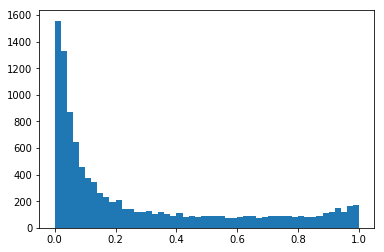

In [3]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist = np.array(y_dist)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [4]:
#Construct PAS-to-matrix-coord dictionary

gene_dict = {}
gene_id_dict = {}
gene_distal_cut_pos_dict = {}

gene_cut_pos_dict = {}

genes = []
gene_ids = []

i = 0
for _, row in df.iterrows() :
    gene_dict[row['gene']] = i
    genes.append(row['gene'])
    gene_distal_cut_pos_dict[row['gene']] = row['cut_mode_' + str(dist_index[i])]
    
    cut_poses = []
    
    for j in range(m.shape[1]) :
        if m[i, j] > 0. :
            gene_id_dict[row['gene_id_' + str(j)]] = j
            gene_ids.append(row['gene_id_' + str(j)])
            cut_poses.append(row['cut_mode_' + str(j)])
    
    gene_cut_pos_dict[row['gene']] = np.array(cut_poses)
    
    i += 1

print("gene_dict['ABCB10'] = " + str(gene_dict['ABCB10']))
print("gene_id_dict['ABCB10.6'] = " + str(gene_id_dict['ABCB10.6']))
print("gene_distal_cut_pos_dict['ABCB10'] = " + str(gene_distal_cut_pos_dict['ABCB10']))
print("gene_cut_pos_dict['ABCB10'] = " + str(gene_cut_pos_dict['ABCB10']))


gene_dict['ABCB10'] = 0
gene_id_dict['ABCB10.6'] = 0
gene_distal_cut_pos_dict['ABCB10'] = 229652139.0
gene_cut_pos_dict['ABCB10'] = [2.29653545e+08 2.29652589e+08 2.29652545e+08 2.29652329e+08
 2.29652175e+08 2.29652139e+08]


In [5]:

def _get_distal_ix(qtl_cut_pos, cut_poses, cutoff_dist=50) :
    
    cands = np.nonzero(np.abs(cut_poses - qtl_cut_pos) <= cutoff_dist)[0]
    
    return cands[-1] if len(cands) > 0 else -1


In [6]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


In [7]:
#Assign all-cut logit to distal-most PAS

for i in range(s.shape[0]) :
    s[i, dist_index[i]] = s_all_cuts[i, dist_index[i]]


Training model...
weights = [ 0.40824775 -0.09564475 -0.69860218  0.45819578 -0.33232693  0.6986014
 -0.68760249 -0.80683027]
Done!
Evaluating...
Spearman r = 0.666
AP = 0.71
n = 10415


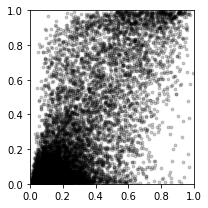

In [10]:
#Fit and evaluate regression model

from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score

load_model = False

model_name_suffix = '_hl'

def logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask) :

    prox_exp = np.exp(w_prox_pas * s + w_prox_hl * hl + w_prox_len * l + w_prox_bias)
    dist_exp = np.exp(w_dist_pas * s + w_dist_hl * hl + w_dist_len * l + w_dist_bias)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, hl, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_len = w_bundle[1]
    w_prox_bias = w_bundle[2]
    w_dist_pas = w_bundle[3]
    w_dist_len = w_bundle[4]
    w_dist_bias = w_bundle[5]
    w_prox_hl = w_bundle[6]
    w_dist_hl = w_bundle[7]
    
    y_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

if not load_model :

    print("Training model...")

    w0 = np.zeros(8)

    res = minimize(logistic_model_mse, w0, args=(s, hl, m, l, dist_mask, y_dist), method='BFGS', options={'disp': False})

    np.save("aparent2_saluki_linear_polyadb" + model_name_suffix + "_w", np.array(res.x))
    
    w_prox_pas = res.x[0]
    w_prox_len = res.x[1]
    w_prox_bias = res.x[2]
    w_dist_pas = res.x[3]
    w_dist_len = res.x[4]
    w_dist_bias = res.x[5]
    w_prox_hl = res.x[6]
    w_dist_hl = res.x[7]

    print("weights = " + str(res.x))

else :
    
    print("Loading model...")
    
    res_x = np.load("aparent2_saluki_linear_polyadb" + model_name_suffix + "_w.npy")
    
    w_prox_pas = res_x[0]
    w_prox_len = res_x[1]
    w_prox_bias = res_x[2]
    w_dist_pas = res_x[3]
    w_dist_len = res_x[4]
    w_dist_bias = res_x[5]
    w_prox_hl = res_x[6]
    w_dist_hl = res_x[7]
    
    print("weights = " + str(res_x))

print("Done!")
print("Evaluating...")

y_dist_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)

spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)

y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])

ap = average_precision_score(y_labels, y_dist_pred)

print("Spearman r = " + str(round(spearman_r_val, 3)))
print("AP = " + str(round(ap, 2)))
print("n = " + str(y_dist.shape[0]))

f = plt.figure(figsize=(3, 3))

plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.tight_layout()
plt.show()


In [19]:
#Prediction interface

def _predict(s, hl, m, l, dist_mask, w_prox_pas=w_prox_pas, w_prox_hl=w_prox_hl, w_prox_len=w_prox_len, w_prox_bias=w_prox_bias, w_dist_pas=w_dist_pas, w_dist_hl=w_dist_hl, w_dist_len=w_dist_len, w_dist_bias=w_dist_bias) :
    
    return logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)


In [20]:
#Tissue types to compile data for

tissue_types = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    #'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c-1',
    'Breast_Mammary_Tissue',
    'Cells_EBV-transformed_lymphocytes',
    'Cells_Transformed_fibroblasts',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    #'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Liver',
    'Lung',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood'
]


In [90]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

save_figs = False

tissue_type = 'Brain'#'Lung'#

keep_unmapped_snps = True

def _determine_distal_ix(row) :
    
    distal_ix = _get_distal_ix(row['qtl_cut_pos'], gene_cut_pos_dict[row['gene']], cutoff_dist=75)

    return distal_ix if distal_ix != -1 else (dist_index[gene_dict[row['gene']]] if keep_unmapped_snps else -1)

blacklist_ids = [
    'chr5_76728085_C_T'
]

snp_pred_df_pas = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_utr3_only_iso_predictions_pred_df.csv", sep='\t')
#snp_pred_df_pas = snp_pred_df_pas.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
snp_pred_df_pas = snp_pred_df_pas.loc[snp_pred_df_pas["tissue_type"].str.contains(tissue_type)].copy().reset_index(drop=True)
snp_pred_df_pas = snp_pred_df_pas.loc[snp_pred_df_pas['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)

snp_pred_df_iso = pd.read_csv("predictions/apa_gtex_data/isoform_merged_utr3_only_iso_lead_SNPs_pred_pmirGLO_construct.csv", sep='\t')
#snp_pred_df_iso = snp_pred_df_iso.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
snp_pred_df_iso = snp_pred_df_iso.loc[snp_pred_df_iso["tissue_type"].str.contains(tissue_type)].copy().reset_index(drop=True)
snp_pred_df_iso = snp_pred_df_iso.loc[snp_pred_df_iso['gene_id'].isin(gene_ids)].copy().reset_index(drop=True)

snp_pred_df_iso['isoform_hl_ref'] = 0.
snp_pred_df_iso['isoform_hl_var'] = 0.

for f in range(10) :
    for c in range(5) :
        snp_pred_df_iso['isoform_hl_ref'] += snp_pred_df_iso['isoform_hl_f' + str(f) + '_c' + str(c) + '_ref']
        snp_pred_df_iso['isoform_hl_var'] += snp_pred_df_iso['isoform_hl_f' + str(f) + '_c' + str(c) + '_var']

snp_pred_df_iso['isoform_hl_ref'] /= 50.
snp_pred_df_iso['isoform_hl_var'] /= 50.

snp_pred_df_pas['snp_pos_pas'] = snp_pred_df_pas['rel_snp_pos'] - 105

snp_pred_df_pas_orig = snp_pred_df_pas.copy()

snp_pred_df_pas_distinct = snp_pred_df_pas.copy()
snp_pred_df_pas_distinct['snp_pos_pas_dist'] = np.abs(snp_pred_df_pas_distinct['snp_pos_pas'] - 76)
snp_pred_df_pas_distinct = snp_pred_df_pas_distinct.sort_values(by=['snp_pos_pas_dist'], ascending=True).drop_duplicates(subset=['snp_id'], keep='first').copy().reset_index(drop=True)

snp_pred_df_iso = snp_pred_df_iso.join(snp_pred_df_pas_distinct[['snp_id', 'snp_pos_pas', 'wide_seq_ext', 'wide_seq_ext_var']].drop_duplicates(subset=['snp_id']).set_index('snp_id'), on='snp_id', how='left')
snp_pred_df_iso.loc[snp_pred_df_iso['snp_pos_pas'].isnull(), 'snp_pos_pas'] = -1

snp_pred_df_pas = snp_pred_df_pas.query("snp_pos_pas >= 0 and snp_pos_pas <= 205").copy().reset_index(drop=True)

#snp_pred_df_iso = snp_pred_df_iso.query("snp_pos_pas < 70 or snp_pos_pas > 76").copy().reset_index(drop=True)
snp_pred_df_iso = snp_pred_df_iso.query("(snp_pos_pas < 70 or snp_pos_pas > 76) and snp_pos_pas != -1").copy().reset_index(drop=True)

#snp_pred_df_pas = snp_pred_df_pas.query("gene == 'NO_GENE'").copy().reset_index(drop=True)
#snp_pred_df_iso = snp_pred_df_iso.query("gene == 'NO_GENE'").copy().reset_index(drop=True)

#Get dataframe of unique SNPs
snp_df = pd.concat([
    snp_pred_df_pas[['snp_id', 'wide_seq_ext', 'wide_seq_ext_var', 'gene_id', 'gene', 'strand', 'chrom', 'pas', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
    snp_pred_df_iso[['snp_id', 'gene_id', 'gene', 'transcript_id', 'snp_pos', 'snp_pos_pas', 'qtl_cut_pos', 'snp_distance', 'n_tissues', 'effect_size', 'p_val', 'mean_PDUI', 'rel_snp_pos']],
]).drop_duplicates(subset=['snp_id', 'transcript_id'], keep='first').sort_values(by='snp_id').copy().reset_index(drop=True)

snp_df['distal_ix'] = snp_df.apply(_determine_distal_ix, axis=1)
snp_df = snp_df.query("distal_ix != -1").copy().reset_index(drop=True)

#Construct ref/var gene-level matrices for each snp
s_ref, s_var = np.zeros((len(snp_df), s.shape[1])), np.zeros((len(snp_df), s.shape[1]))
hl_ref, hl_var = np.zeros((len(snp_df), hl.shape[1])), np.zeros((len(snp_df), hl.shape[1]))
m_ref, m_var = np.zeros((len(snp_df), m.shape[1])), np.zeros((len(snp_df), m.shape[1]))
l_ref, l_var = np.zeros((len(snp_df), l.shape[1])), np.zeros((len(snp_df), l.shape[1]))
dist_mask_ref, dist_mask_var = np.zeros((len(snp_df), dist_mask.shape[1])), np.zeros((len(snp_df), dist_mask.shape[1]))

i = 0
for _, row in snp_df.iterrows() :

    s_ref[i, :], s_var[i, :] = s[gene_dict[row['gene']], :], s[gene_dict[row['gene']], :]
    hl_ref[i, :], hl_var[i, :] = hl[gene_dict[row['gene']], :], hl[gene_dict[row['gene']], :]
    m_ref[i, :], m_var[i, :] = m[gene_dict[row['gene']], :], m[gene_dict[row['gene']], :]
    l_ref[i, :], l_var[i, :] = l[gene_dict[row['gene']], :], l[gene_dict[row['gene']], :]

    dist_mask_ref[i, row['distal_ix']], dist_mask_var[i, row['distal_ix']] = 1., 1.
    
    #Fill in variant predictions
    snp_pred_df_pas_subset = snp_pred_df_pas.query("snp_id == '" + row['snp_id'] + "'")
    for _, pas_row in snp_pred_df_pas_subset.iterrows() :

        pred_suffix = '' if gene_id_dict[pas_row['gene_id']] != dist_index[gene_dict[pas_row['gene']]] else '_all_cuts'

        s_ref[i, gene_id_dict[pas_row['gene_id']]] = pas_row['ref_isoform_logodds' + pred_suffix]
        s_var[i, gene_id_dict[pas_row['gene_id']]] = pas_row['var_isoform_logodds' + pred_suffix]

    snp_pred_df_iso_subset = snp_pred_df_iso.query("snp_id == '" + row['snp_id'] + "'")
    for _, iso_row in snp_pred_df_iso_subset.iterrows() :

        hl_ref[i, gene_id_dict[iso_row['gene_id']]] = iso_row['isoform_hl_ref']
        hl_var[i, gene_id_dict[iso_row['gene_id']]] = iso_row['isoform_hl_var']

    i += 1

PDUI_pred_ref = np.clip(_predict(s_ref, hl_ref, m_ref, l_ref, dist_mask_ref), 1e-7, 1. - 1e-7)
PDUI_pred_var = np.clip(_predict(s_ref, hl_var, m_var, l_var, dist_mask_var), 1e-7, 1. - 1e-7)
snp_df['delta_isoform_logodds'] = np.log(PDUI_pred_var / (1. - PDUI_pred_var)) - np.log(PDUI_pred_ref / (1. - PDUI_pred_ref))

snp_df['n_affected'] = np.sum(np.abs(hl_var - hl_ref) > 0., axis=-1)

snp_pred_df = snp_df.copy()

#PDUI
snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds']))
snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

filtered_df = lead_snp_pred_df

filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]


In [91]:

filtered_df.sort_values(by='delta_isoform_logodds')[['snp_id', 'gene_id', 'snp_pos_pas', 'effect_size', 'delta_isoform_logodds']]


,snp_id,gene_id,snp_pos_pas,effect_size,delta_isoform_logodds
21,chr18_9285892_T_G,ANKRD12.16,4.0,-0.042554,-0.017519
42,chr4_6885815_T_C,KIAA0232.13,14.0,-0.057399,-0.015722
1,chr12_57489648_C_T,STAT6.1,212.0,-0.212438,-0.006249
0,chr10_98104703_C_T,OPALIN.1,-6.0,0.088504,-0.006094
26,chr1_151846517_C_T,THEM4.6,107.0,0.068321,-0.005708
34,chr20_6018711_G_A,CRLS1.9,112.0,-0.098213,-0.004959
50,chr5_176728400_G_A,RAB24.5,148.0,-0.030726,-0.004564
61,chr9_123151125_G_T,CDK5RAP2.4,120.0,-0.090632,-0.004385
35,chr2_3502035_C_T,ADI1.7,58.0,-0.134547,-0.003472
16,chr17_37223458_G_A,PLXDC1.4,19.0,0.053766,-0.002531


In [89]:
#Lung

snp_id = 'chr1_52818188_G_A'

snp_pos_pas = int(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['snp_pos_pas'])

print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['gene_id'])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['strand'])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['chrom'])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['snp_pos'])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['effect_size'])
print(snp_pos_pas)
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['delta_isoform_logodds'])

print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['wide_seq_ext'][175-70+snp_pos_pas-50:175-70+snp_pos_pas+50])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['wide_seq_ext_var'][175-70+snp_pos_pas-50:175-70+snp_pos_pas+50])
print("")
print(s_ref[filtered_df.query("snp_id == '" + snp_id + "'").index[0]])
print(s_var[filtered_df.query("snp_id == '" + snp_id + "'").index[0]])
print("")
print(hl_ref[filtered_df.query("snp_id == '" + snp_id + "'").index[0]])
print(hl_var[filtered_df.query("snp_id == '" + snp_id + "'").index[0]])

print("")
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['wide_seq_ext'][175-70:175-70+205])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['wide_seq_ext_var'][175-70:175-70+205])


CC2D1B.9
-
chr1
52818188
-0.0360867677391151
101
0.05711001583252884
CTGGAAGAAAAAATATATATATAAAATTTTATGTAGACACGTTTATTTATCTAGGAAACTAAGTCTAACTCATTGTAGGGATTTTATACTCAACTATACA
CTGGAAGAAAAAATATATATATAAAATTTTATGTAGACACGTTTATTTATTTAGGAAACTAAGTCTAACTCATTGTAGGGATTTTATACTCAACTATACA

[-3.0661469  -4.87251568 -0.91124445 -2.54318571 -1.83078492 -0.29565933
 -4.58157063 -2.2959826  -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.        ]
[-2.7987788  -4.87251568 -0.91124445 -2.54318571 -1.83078492 -0.29565933
 -4.58157063 -2.2959826  -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.        ]

[-0.94582336 -0.7769648  -0.69768433 -0.706

In [92]:

snp_id = 'chr16_420907_T_C'

snp_pos_pas = int(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['snp_pos_pas'])

print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['gene_id'])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['strand'])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['chrom'])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['snp_pos'])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['effect_size'])
print(snp_pos_pas)
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['delta_isoform_logodds'])

print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['wide_seq_ext'][175-70+snp_pos_pas-50:175-70+snp_pos_pas+50])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['wide_seq_ext_var'][175-70+snp_pos_pas-50:175-70+snp_pos_pas+50])
print("")
print(s_ref[filtered_df.query("snp_id == '" + snp_id + "'").index[0]])
print(s_var[filtered_df.query("snp_id == '" + snp_id + "'").index[0]])
print("")
print(hl_ref[filtered_df.query("snp_id == '" + snp_id + "'").index[0]])
print(hl_var[filtered_df.query("snp_id == '" + snp_id + "'").index[0]])

print("")
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['wide_seq_ext'][175-70:175-70+205])
print(filtered_df.query("snp_id == '" + snp_id + "'").iloc[0]['wide_seq_ext_var'][175-70:175-70+205])


TMEM8A.3
-
chr16
420907
0.10552399060453599
50
0.14336535502586878
CCCTGCACTTGACCACCAAAGCAATCTCTAAGCTTATAAAGGAGAAACATATATATATGGGGTTTTTTGGAGTAAAGGAAAATTCTAAGATATTAAGACA
CCCTGCACTTGACCACCAAAGCAATCTCTAAGCTTATAAAGGAGAAACATGTATATATGGGGTTTTTTGGAGTAAAGGAAAATTCTAAGATATTAAGACA

[-2.15836477 -3.9522424  -2.24882841 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.        ]
[-2.15836477 -3.0291057  -2.24882841 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.        ]

[-0.12902185 -0.70447852 -0.8384683   0.          0.         